In [ ]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.8/34.8 MB 27.1 MB/s eta 0:00:00


In [ ]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import cv2
from google.colab.patches import cv2_imshow
import math
import numpy as np
from PIL import Image

In [ ]:
# The Shape of the HairSegmenter Model Input Model is 512x512
INPUT_HEIGHT = 512
INPUT_WIDTH = 512

In [ ]:
PATH_IMG = "/content/drive/MyDrive/dataset/_w-619fe54dc9e26.jpg"

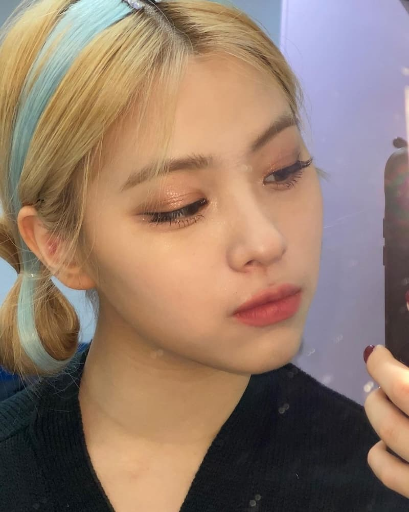

In [ ]:


# Resizing and Showing the image
def resize_and_show(image):
  h, w = image.shape[:2]
  if h < w:
    img = cv2.resize(image, (INPUT_WIDTH, math.floor(h/(w/INPUT_WIDTH))))
  else:
    img = cv2.resize(image, (math.floor(w/(h/INPUT_HEIGHT)), INPUT_HEIGHT))
  cv2_imshow(img)

img = cv2.imread(PATH_IMG)

resize_and_show(img)

In [ ]:
BG_COLOR = (0, 0, 0) # Background RGB Color
MASK_COLOR = (255, 255, 255) # Mask RGB Color

In [ ]:
HAIR_SEGMENTER_MODEL_PATH = "/content/hair_segmenter.tflite"

In [ ]:
# Create the options that will be used for ImageSegmenter
base_options = python.BaseOptions(model_asset_path='/content/hair_segmenter.tflite')
options = vision.ImageSegmenterOptions(base_options=base_options,
                                       output_category_mask=True)

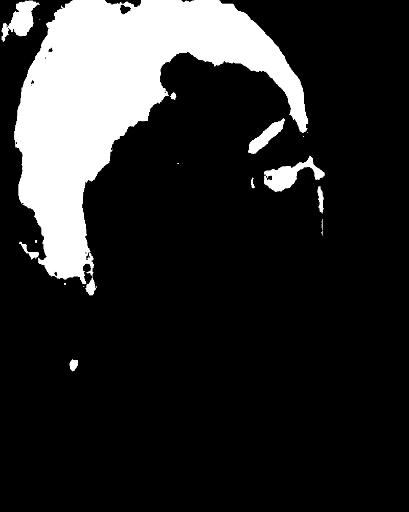

In [ ]:
# Creating the Hair Mask
with vision.ImageSegmenter.create_from_options(options) as segmenter:
  # Loading Original Image
  image = mp.Image(image_format=mp.ImageFormat.SRGB, data=img)

  # Retrieve the masks for the segmented image
  segmentation_result = segmenter.segment(image)
  category_mask = segmentation_result.category_mask

  # Generate solid color images for showing the output segmentation mask.
  image_data = image.numpy_view()
  fg_image = np.zeros(image_data.shape, dtype=np.uint8)
  fg_image[:] = MASK_COLOR
  bg_image = np.zeros(image_data.shape, dtype=np.uint8)
  bg_image[:] = BG_COLOR

  condition = np.stack((category_mask.numpy_view(),) * 3, axis=-1) > 0.2
  output_image = np.where(condition, fg_image, bg_image)

  #Saving the Hair Mask Image
  cv2.imwrite("hair_mask.png", output_image)

  resize_and_show(output_image)

In [ ]:
import cv2
import numpy as np
from sklearn.mixture import GaussianMixture

# Step 1: Load the segmented hair mask
hair_mask = cv2.imread("hair_mask.png", cv2.IMREAD_GRAYSCALE)

# Check if the hair mask is loaded successfully
if hair_mask is None:
    print("Error: Unable to load the hair mask.")
    exit()

# Step 2: Load the original image
image = cv2.imread("/content/drive/MyDrive/dataset/_w-619fe54dc9e26.jpg")

# Check if the original image is loaded successfully
if image is None:
    print("Error: Unable to load the original image.")
    exit()

# Resize the hair mask to match the dimensions of the image
hair_mask = cv2.resize(hair_mask, (image.shape[1], image.shape[0]))

# Step 3: Extract hair pixels using the mask
hair_pixels = image[hair_mask > 0]  # Extract hair pixels
hair_features = hair_pixels.reshape(-1, 3)  # Convert to feature vectors (RGB values)

# Step 4: Apply Gaussian Mixture Model clustering
gmm = GaussianMixture(n_components=2)  # Assuming there are two hair colors (majority and minority)
gmm.fit(hair_features)

# Step 5: Identify minority cluster
cluster_assignments = gmm.predict(hair_features)
minority_cluster_label = np.argmin(np.bincount(cluster_assignments))  # Find the minority cluster label

# Step 6: Extract minority hair color
minority_cluster_indices = np.where(cluster_assignments == minority_cluster_label)[0]
minority_hair_pixels = hair_features[minority_cluster_indices]
minority_hair_color = np.mean(minority_hair_pixels, axis=0)

print("Minority Hair Color (RGB):", minority_hair_color)
# Step 7: Extract majority hair color
majority_cluster_label = 1 - minority_cluster_label  # The majority cluster label is the opposite of the minority label
majority_cluster_indices = np.where(cluster_assignments == majority_cluster_label)[0]
majority_hair_pixels = hair_features[majority_cluster_indices]
majority_hair_color = np.mean(majority_hair_pixels, axis=0)

print("Majority Hair Color (RGB):", majority_hair_color)



Minority Hair Color (RGB): [152.91994914 170.31690261 169.18425878]
Majority Hair Color (RGB): [ 84.55819593 124.98242103 158.37914456]


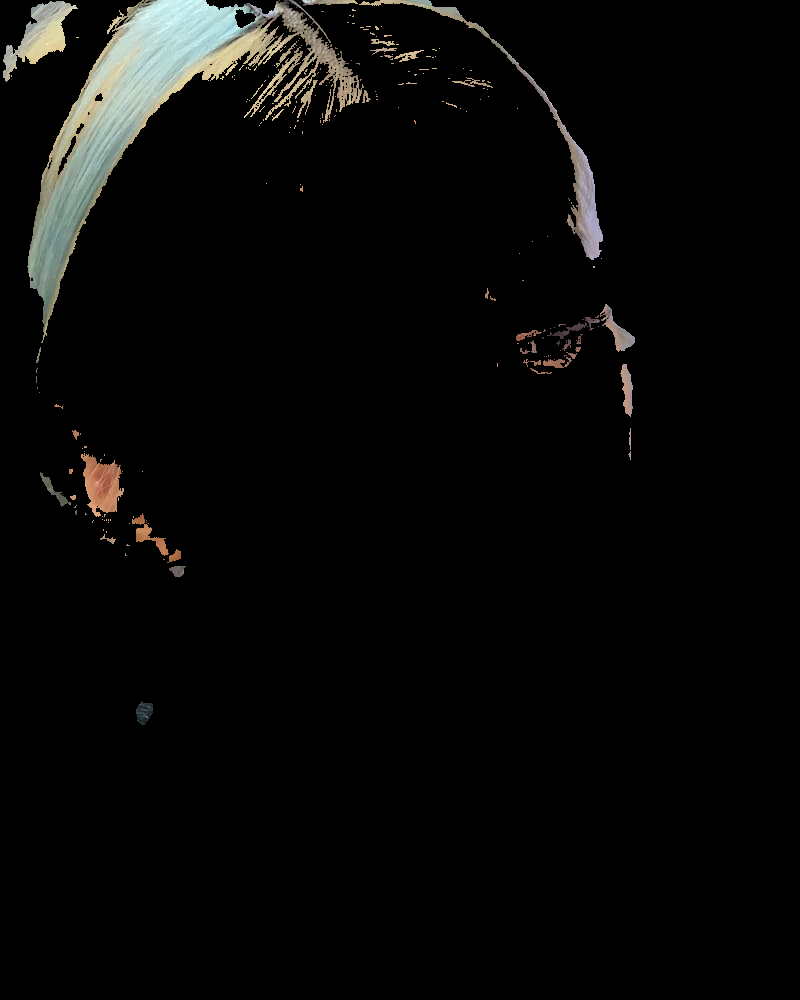

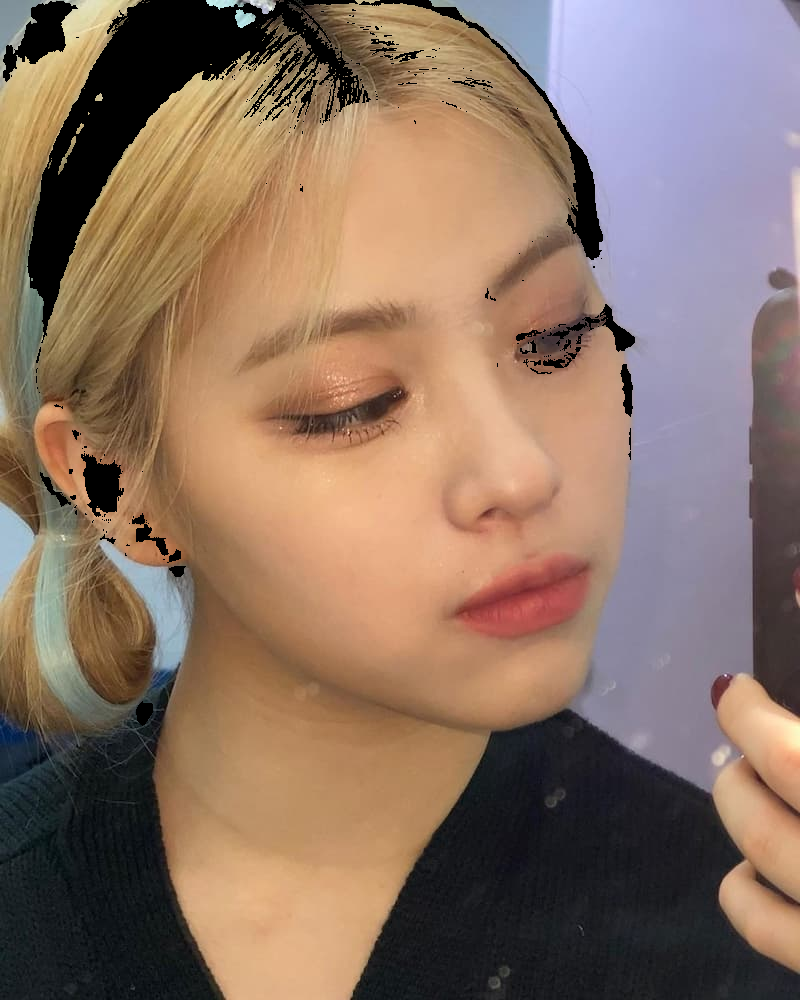

In [ ]:
# Step 1: Load the segmented hair mask
hair_mask = cv2.imread("hair_mask.png", cv2.IMREAD_GRAYSCALE)

# Check if the hair mask is loaded successfully
if hair_mask is None:
    print("Error: Unable to load the hair mask.")
    exit()

# Step 2: Load the original image
image = cv2.imread("/content/drive/MyDrive/dataset/_w-619fe54dc9e26.jpg")

# Check if the original image is loaded successfully
if image is None:
    print("Error: Unable to load the original image.")
    exit()

# Resize the hair mask to match the dimensions of the image
hair_mask = cv2.resize(hair_mask, (image.shape[1], image.shape[0]))

# Step 3: Extract hair pixels using the mask
hair_pixels = image[hair_mask > 0]  # Extract hair pixels
hair_features = hair_pixels.reshape(-1, 3)  # Convert to feature vectors (RGB values)

# Step 4: Apply Gaussian Mixture Model clustering
gmm = GaussianMixture(n_components=2)  # Assuming there are two hair colors (majority and minority)
gmm.fit(hair_features)

# Step 5: Identify minority cluster
cluster_assignments = gmm.predict(hair_features)
minority_cluster_label = np.argmin(np.bincount(cluster_assignments))  # Find the minority cluster label

# Step 6: Create a binary mask for the minority hair color
mask = np.zeros_like(hair_mask)
mask[hair_mask > 0] = np.where(cluster_assignments == minority_cluster_label, 255, 0)

# Step 7: Apply the mask to the original image
masked_image = cv2.bitwise_and(image, image, mask=mask)

# Step 8: Invert the mask to black out the majority part
black_mask = cv2.bitwise_not(mask)

# Apply the inverted mask to the original image
blackout_image = cv2.bitwise_and(image, image, mask=black_mask)

# Display the masked image and the blacked-out image
from google.colab.patches import cv2_imshow
cv2_imshow(masked_image)
cv2_imshow(blackout_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


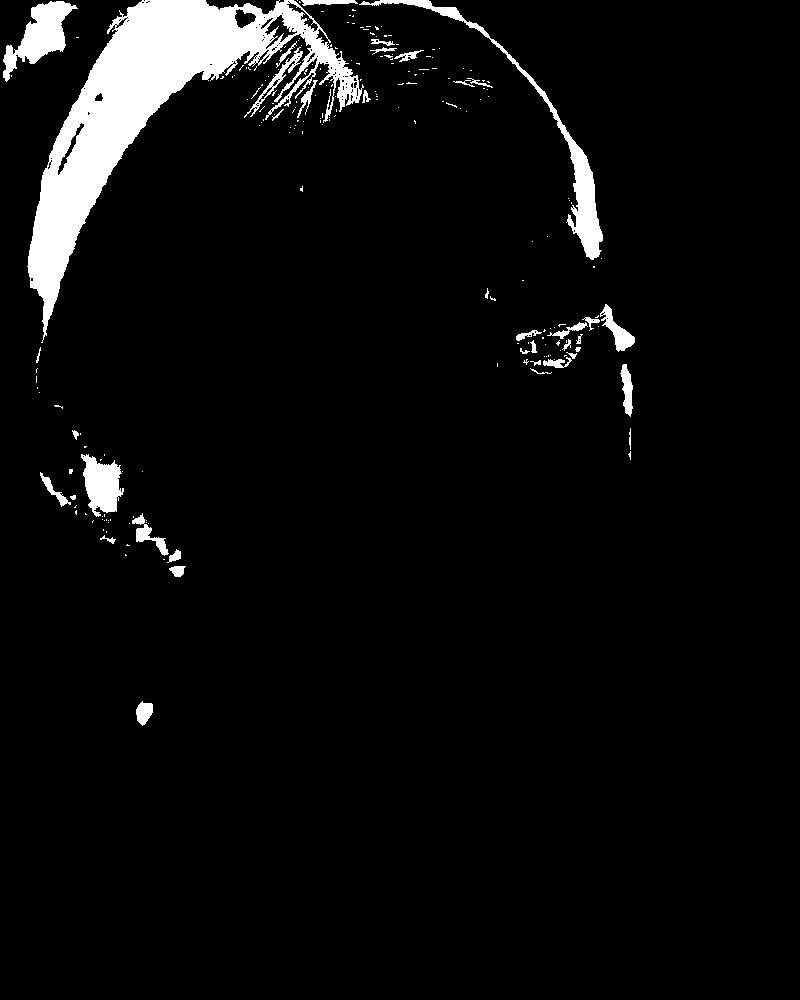

In [ ]:
# Step 1: Load the segmented hair mask
hair_mask = cv2.imread("hair_mask.png", cv2.IMREAD_GRAYSCALE)

# Check if the hair mask is loaded successfully
if hair_mask is None:
    print("Error: Unable to load the hair mask.")
    exit()

# Step 2: Load the original image
image = cv2.imread("/content/drive/MyDrive/dataset/_w-619fe54dc9e26.jpg")

# Check if the original image is loaded successfully
if image is None:
    print("Error: Unable to load the original image.")
    exit()

# Resize the hair mask to match the dimensions of the image
hair_mask = cv2.resize(hair_mask, (image.shape[1], image.shape[0]))

# Step 3: Extract hair pixels using the mask
hair_pixels = image[hair_mask > 0]  # Extract hair pixels
hair_features = hair_pixels.reshape(-1, 3)  # Convert to feature vectors (RGB values)

# Step 4: Apply Gaussian Mixture Model clustering
gmm = GaussianMixture(n_components=2)  # Assuming there are two hair colors (majority and minority)
gmm.fit(hair_features)

# Step 5: Identify minority cluster
cluster_assignments = gmm.predict(hair_features)
minority_cluster_label = np.argmin(np.bincount(cluster_assignments))  # Find the minority cluster label

# Step 6: Create a binary mask for the minority hair color
mask = np.zeros_like(hair_mask)
mask[hair_mask > 0] = np.where(cluster_assignments == minority_cluster_label, 255, 0)

# Step 7: Invert the mask to make minority hair white and everything else black
inverted_mask = cv2.bitwise_not(mask)

# Step 8: Invert the inverted mask again to change black to white and white to black
final_mask = cv2.bitwise_not(inverted_mask)

# Display the final inverted mask
from google.colab.patches import cv2_imshow
cv2_imshow(final_mask)
cv2.waitKey(0)
cv2.destroyAllWindows()
